# Spiked-in Data Prep for QuestVar

- **License:** [MIT License](https://opensource.org/licenses/MIT)
- **Version:** 0.2
- **Edit Log:** 
    - 2024-01-19: Initial version of the notebook
    - 2024-02-21: Revised the notes 

**Data Information:**

The data utilized in this notebook is sourced from [Yu et al. 2023](https://www.nature.com/articles/s41467-023-39869-5) and downloaded "benchmark_diann.zip" from [Zenodo Repo](https://zenodo.org/records/7859138). The spiked-in dataset consists of 23 replicates per 4 samples (92 total samples). The first sample is the origin sample called "Lypmhnode," which consists solely of human proteins. The remaining three samples are spiked in with E.coli peptides using the ratio system. For instance, the sample 1:25 (or 1-25) is spiked in with E.coli peptides at a ratio of 1:25 (ecoli: human). The other two samples are 1:12 and 1:06. Where the 1:12 sample is spiked-in with E.coli peptides at a ratio of 1:12 (ecoli: human), and the 1:06 sample is spiked-in with E.coli peptides at a ratio of 1:06 (ecoli: human). The data is provided as a fasta file and a protein-level quantification file.

> **Note:** The sample names are changed to A, B, C, and D for simplicity in the manuscript. Sample A is the "Lymphnode" reference sample, and samples B, C, and D are spiked in with E.coli peptides at ratios 1:25, 1:12, and 1:06, respectively. But here in the notebook, the original sample names are used.

To use this data in my analysis, I extracted the two essential files; "2022-02-18-reviewed-UP000005640-UP000000625.fas" representing the fasta, and "protein_maxlfq.tsv" representing quantitative protein level data.

Both data files must be in the same directory as the notebook within the `data/raw/` folder. After running the notebook, the processed data files will be generated in the `data/processed/` folder. A series of figures will be generated alongside the processed data files in the `figures/` folder.

**Notebook Summary:**

Before the direct application of `questvar` on the data, preliminary steps are performed. These include a data check, cleaning, and processing. The notebook facilitates data check-ups, simple clean-up procedures, and visualizations to explore sample completeness and organism effects. Finally, processed data files are generated for utilization in the `questvar` framework in the subsequent notebook.

## Setup Notebook

This part is a standard for my notebooks, where I import all the used libraries, set the notebook's design, and define the paths for data and figures. 

> **Note:** The HTML rendering of this notebook will not show the code cells by default, but the code can be visible by clicking the "code" buttons aligned on the right.

### Libraries Used

In [1]:
import os 
import sys
import feather # fast, efficient file for i/o

import numpy as np # numerical computing
import pandas as pd # data handling

import seaborn as sns # R-like high-level plots
import matplotlib.pyplot as plt # Python's base plotting 
import matplotlib.ticker as mtick # Format tick marks on plots

sys.path.append('../') # Expand the path to parent dir
from questvar import utils, plots # Import custom modules

import warnings; warnings.filterwarnings('ignore')
# Initialize the timer
startTime = utils.getTime()

### Notebook's Design

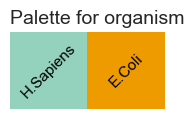

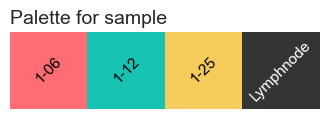

In [2]:
### Notebook Configuration

# Set random seed
np.random.seed(42)

# Colors
organism_colors = {
    "H.Sapiens": "#94d2bd",
    "E.Coli": "#ee9b00",
}
sample_labels = {
    '1-06': '#fe6d73',
    '1-12': '#17c3b2',
    '1-25': '#f5cb5c',
    'Lymphnode': '#333533'
}

## Configure some general styling for the plots

# Set the default style
sns.set_theme(
    style="white",
    context="paper",
    # palette=def_colors,
    font_scale=1,
    rc={
        "figure.figsize": (6, 4),
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial"],
    }
)

# Figure Saving Settings
figure_formats = ["png", "pdf"] # formats to save figures in
save_to_folder = True           # enable saving figures to folder
transparet_bg = True            # enable transparent background
figure_dpi = 300                # figure resolution

## Configure dataframe displaying
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 25)

## Color Palettes used

# Organism colors
plots.color_palette(
    organism_colors,
    name = "organism"
)
# Sample colors
plots.color_palette(
    sample_labels,
    name = "sample"
)

### Data and Result Paths

For better organization, I keep the data and figures in separate folders. Additionally, within the data folder, I create sub-folders for raw data, processed data, and notebook results to distinguish each process step.

The *`data/raw/`* folder, where the original data resides, must be present from the outset. However, as they are not initially present, I will create the *`data/processed/`* and *`results/`* folders within the notebook.

The *`data/processed/samples/`* folder stores subset files that the primary testing function uses when comparing two samples. I save these subsets separately because as the number of samples grows, and when testing all sample combinations, it's more efficient to access subsets rather than continually subsetting from a large table. This approach also optimizes memory usage, benefiting future storage.

Lastly, I created the *`figures/`* folder to store all figures generated in the notebook. Depending on the number of formats you wish to save, subset folders will house the saved figures in those respective formats.

In [3]:
# Establish the paths
notebook_name = "dataPrep"
data_path = "./data/"                           # Main data folder
fig_path = f"./figures/{notebook_name}/"        # Main figure folder
input_path = f"{data_path}raw/"                 # Input data folder
output_path = f"{data_path}processed/"          # Output data folder
quant_path = f"{output_path}samples/"           # Folder for Subset of sample feather files 
supp_path = f"{data_path}supplementary/"        # Supplementary data folder (for Manuscript)

# Check if data/raw folder exists
if not os.path.exists(input_path):
    raise FileNotFoundError(
        "Data folder not found. Please follow the instructions in the README.md file."
    )

# Create folders for output and quant
for i in [output_path, quant_path, supp_path]:
    if not os.path.exists(i):
        os.makedirs(i)

# Create figure folder structure, if needed
if save_to_folder: 
    for i in figure_formats:
        cur_folder = fig_path + i + "/"
        if not os.path.exists(cur_folder):
            os.makedirs(cur_folder)   

## Setup the Data

After the notebook is set up, I start with the raw data and make them usable. Overall, my approach stays the same, but depending on the data, changes will be required. 

### Fasta Mapper

A specific fasta is provided by the source alongside the protein file. As part of the data setup process, I parsed the fasta into a pandas table, keeping helpful information such as the protein name, gene name, and protein sequence length. I also check and review the isoform status to learn if the fasta contains any isoforms or unreviewed proteins. 

Since the data contains spiked-in E.coli, the fasta provided contains both Human and E.coli proteins. I created the organism column from the entry name column and standardized their name.

In [4]:
protein_info = utils.fasta_to_df(
    input_path + "2022-02-18-reviewed-UP000005640-UP000000625.fas", 
    "" # Fasta Identifier (Ignored for this)
)
print("Unique isoform status:", protein_info["isoformStatus"].unique())
print("Unique review status:", protein_info["reviewStatus"].unique())
# Select only the columns of interest
protein_info = protein_info[[
    "entry",
    "entryName",
    "geneName", 
    "sequenceLength"
]]
protein_info["organism"] = protein_info["entryName"].str.split("_").str[1]
protein_info["organism"] = protein_info["organism"].replace({
    "ECOLI": "E.Coli",
    "HUMAN": "H.Sapiens"
})
protein_info["organism"].value_counts()

Unique isoform status: ['canonical']
Unique review status: ['reviewed']


H.Sapiens    20206
E.Coli        4380
Name: organism, dtype: int64

### Protein Level Quant Data

The protein level quant data is provided as a TSV file. I read the file into a Pandas table and checked the columns. The first column, containing the protein IDs, is set as the index.

Since some proteins do not have any unique peptides that form them, search software often creates a "proteinGrouping" column that groups them in the format "ProteinID1;ProteinID2". For ease of use and mapping to the fasta table, I simplify this by selecting a representative protein ID and keeping only that. To do this, I first check for more than one protein ID. If so, I choose the first 6-character protein ID as the representative. Six characters are given priority as they make up the majority of the database and are more likely to be primary accession numbers than 10-character ones. If no 6-character protein ID is found, the first 10-character protein ID is selected.

> [Source: UniProt](https://www.uniprot.org/help/accession_numbers)


Another step is ensuring all proteins within the quantitative data have a fasta entry. To do this, I compare the protein IDs in the fasta table with those in the quant table. If there is a protein ID in the quant table that is not in the fasta table, I ignore that protein in the quant table. This results in the removal of 15 proteins.

In [5]:
data = pd.read_csv(
    input_path+'protein_maxlfq.tsv', 
    sep="\t",
    index_col=0
)
# Remove the "REV__" and "CON__" from the protein names
# If multiple proteins are present, select a representative one
# (the first one with 6-letter code)
data.index = data.index.map(
    utils.select_representative_protein
)
print("Number of proteins:", data.shape[0])
print("Number of columns:", data.shape[1])

# Make sure the index and protein_info entry column are the same
data = data.loc[data.index.isin(protein_info["entry"])]
print("After fasta-maching, number of proteins:", data.shape[0])
# Create a data.index: protein_info.organism mapping
org_map = protein_info.set_index("entry")["organism"].to_dict()
data.head()

Number of proteins: 6817
Number of columns: 92
After fasta-maching, number of proteins: 6802


,Lymph_043,Lymph_Ecoli_1-12_092,Lymph_Ecoli_1-25_102,Lymph_Ecoli_1-12_022,Lymph_Ecoli_1-6_053,Lymph_Ecoli_1-25_047,Lymph_Ecoli_1-12_024,Lymph_Ecoli_1-25_101,Lymph_Ecoli_1-25_019,Lymph_075,Lymph_Ecoli_1-25_083,Lymph_Ecoli_1-12_091,...,Lymph_Ecoli_1-25_064,Lymph_Ecoli_1-6_095,Lymph_Ecoli_1-6_097,Lymph_031,Lymph_Ecoli_1-12_052,Lymph_098,Lymph_076,Lymph_017,Lymph_Ecoli_1-6_055,Lymph_Ecoli_1-25_033,Lymph_Ecoli_1-12_069,Lymph_Ecoli_1-25_006
Q86U42,516491.2496,449728.9161,585229.0835,671532.2234,506318.9739,551206.9243,583417.2538,549250.7723,613839.1230,467247.2565,478445.1170,444527.6776,...,629678.3176,476894.6795,418973.9113,500107.2297,514958.0834,570861.2686,555498.0765,587342.2682,509490.8268,636899.7977,509305.9890,565708.7885
P37108,771554.7089,861472.1142,726212.4053,899428.3144,898993.1767,834385.6676,915198.3268,562562.6101,786967.1018,722705.4980,783455.8872,631227.9213,...,787372.9460,952326.7184,722270.4750,788259.0483,1020263.8195,672281.2089,869739.9696,798300.1133,903949.7069,761241.3018,846984.0219,784132.0192
Q96JP5,346146.2404,338120.1308,223641.0512,446091.0662,361407.6293,345542.6200,319045.1616,210865.2951,438820.8022,365354.7815,332376.6977,447655.3556,...,229632.3478,333588.2935,385200.1859,278177.9803,392494.9698,272033.3245,241468.5557,296003.5736,345125.5870,325757.9322,412009.0948,NaN
Q8N697,410262.0000,502189.0000,436200.0000,NaN,920834.0000,575635.0000,255044.0000,621270.0000,NaN,592098.0000,634370.0000,834362.0000,...,370848.0000,349385.0000,465406.0000,523377.0000,626427.0000,453288.0000,391330.0000,225459.0000,497771.0000,566211.0000,591588.0000,NaN
O75822,446195.4599,536343.0567,529361.2223,640388.4396,503476.2175,448537.6740,626899.8960,423621.5227,649039.9202,479454.8011,457853.0122,527378.1169,...,461258.8501,529161.3565,429783.3607,440175.3291,642400.3448,518179.5013,609592.9940,469434.4712,513552.8636,530116.6669,491799.0323,484931.9408


### Make a Metadata Table

Since the makeup of the samples is simple enough to manually build in a table as metadata, I opted to create a manual metadata table. This metadata is very simple, containing columnName column containing the original sample+replica names from the quant data and extracting the information of which data they belong to. The sample column represents the four samples; "Lypmhnode", "1-06", "1-12", and "1-25". 

In [6]:
metadata = pd.DataFrame()
metadata["columnName"] = data.columns
metadata["Sample"] = "Lymphnode"
metadata.loc[metadata.columnName.str.contains("1-6"), "Sample"] = "1-06"
metadata.loc[metadata.columnName.str.contains("1-12"), "Sample"] = "1-12"
metadata.loc[metadata.columnName.str.contains("1-25"), "Sample"] = "1-25"
metadata.value_counts("Sample")
print("Number of samples:", metadata.shape[0])
print("Sample -> Number of replicates")
utils.print_series(metadata["Sample"].value_counts())
metadata.head()

Number of samples: 92
Sample -> Number of replicates
 Lymphnode -> 23
 1-12 -> 23
 1-25 -> 23
 1-06 -> 23


,columnName,Sample
0,Lymph_043,Lymphnode
1,Lymph_Ecoli_1-12_092,1-12
2,Lymph_Ecoli_1-25_102,1-25
3,Lymph_Ecoli_1-12_022,1-12
4,Lymph_Ecoli_1-6_053,1-06


# Initial Look of the Data

In [7]:
sample_order = ["1-06", "1-12", "1-25", "Lymphnode"] # Specific order for the samples
col_samp = dict(zip(metadata.columnName, metadata.Sample)) 
samp_col = metadata.groupby("Sample").apply(lambda x: list(x["columnName"])).to_dict()

## Density of Replicates

The density of all replicates was plotted on a log2 scale to observe the differences between the samples. Each replicate was represented as a coloured line based on its corresponding sample.

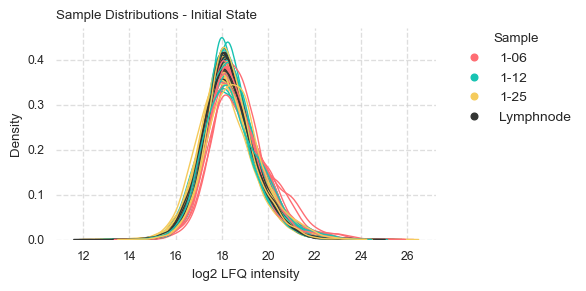

In [8]:
fig, ax = plt.subplots(figsize=(6, 3))
for s, g in col_samp.items():
    sns.kdeplot(
        data=np.log2(data[s]),
        ax=ax,
        color=sample_labels[g],
        linewidth=1,
        fill=False,
        label=None,
    )
ax.set_xlabel("log2 LFQ intensity")
ax.set_ylabel("Density")
ax.set_title("Sample Distributions - Initial State", loc="left")
# Create a legend
handles = [
    plt.Line2D(
        [], [],
        color=cl,
        marker="o",
        linestyle="",
        label=ts,
    ) for ts, cl in sample_labels.items()
]
ax.legend(
    handles=handles,
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0,
    title="Sample",
    prop={"size": 10},
    frameon=False,
)
# Add grid
ax.grid(
    axis="both",
    which="major",
    color="lightgrey",
    linestyle="--",
    linewidth=.95,
    alpha=0.75,
)

sns.despine(
    left=True,
    bottom=True,
)
plt.tight_layout()

# Save the figure, if save_to_folder is True
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = "InitialState_ReplicateDistributions",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

Upon initial inspection, no significant shifts or peaks suggest a major difference between the samples. However, some minor variations can be observed. For instance, the 1-06 sample exhibits slightly higher density in specific areas compared to the other samples. This is likely due to the influence of E.coli proteins on those replicates.

## Intra-sample Coefficient of Variation

The intra-sample coefficient of variation (CV) is a commonly used method for assessing the reproducibility of samples. It calculates the protein-wise CV using non-scaled intensity values and presents it as a violin or box plot. In this case, a violin plot was used to visualize the distribution of CVs for each sample.

Intra-CV(%) of each sample (23 replicates)
Median
 1-06 -> 26.444
 1-12 -> 26.488
 1-25 -> 26.158
 Lymphnode -> 22.673
---------------
Mean
 1-06 -> 30.688
 1-12 -> 29.722
 1-25 -> 31.456
 Lymphnode -> 28.211


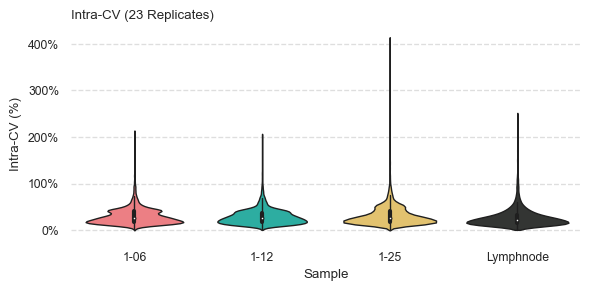

In [9]:
intra_cv = pd.DataFrame()
for c, s in samp_col.items():
    cur_data = data[s]
    intra_cv[c] = cur_data[s].std(axis=1) / cur_data[s].mean(axis=1) * 100

# Initialize the figure
fig, ax = plt.subplots(figsize=(6, 3))
# Plot the data
sns.violinplot(
    data=intra_cv,
    palette=sample_labels,
    ax=ax,
    linewidth=1,
    cut=0,
    order=sample_order,
)
# Set the axis labels
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_xlabel("Sample")
ax.set_ylabel("Intra-CV (%)")
ax.set_title("Intra-CV (23 Replicates)", loc="left")
# Grid
ax.grid(
    axis="y",
    which="major",
    color="lightgrey",
    linestyle="--",
    linewidth=.95,
    alpha=0.75,
)
sns.despine(
    left=True,
    bottom=True,
)
plt.tight_layout()

# Save the figure, if save_to_folder is True
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = "InitialState_IntraCV_Violin",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

print("Intra-CV(%) of each sample (23 replicates)")
utils.print_series(
    series = intra_cv.median().round(3),
    header = "Median"
)
print("-"*15)
utils.print_series(
    series = intra_cv.mean().round(3),
    header = "Mean"
)

The median CV percentages for the spiked-in samples are approximately 26%, while the original human-only sample has the lowest value at 22%. The presence of E.coli proteins increases the variability of the replicates. Additionally, it is worth noting that the outliers for 1-25 exhibit unusually high values.

## Quantified Protein Counts

The number of quantified proteins in each sample was visualized using a bar plot. The height of each bar represents the number of proteins quantified, and an error line at the top of each bar indicates the standard deviation of the protein counts across replicates. A black dashed line was drawn to represent all samples' fully quantified protein count.

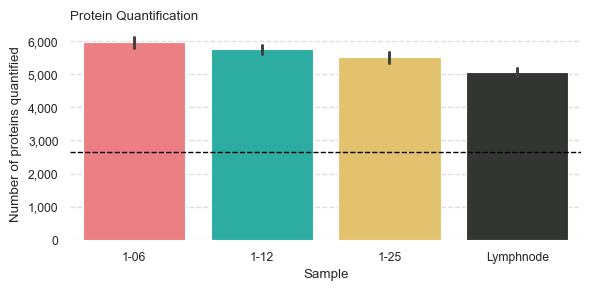

In [10]:
plot_data = data.isna().sum().to_frame().rename(columns={0: "NA"})
plot_data["Quantified"] = data.shape[0] - plot_data["NA"]
plot_data["Sample"] = plot_data.index.map(col_samp)
plot_data = plot_data.sort_values(["Sample", "Quantified"])
# Initialize the figure and axes
fig, ax = plt.subplots(figsize=(6, 3))
# Facet by Sample
sns.barplot(
    data=plot_data,
    x="Sample",
    y="Quantified",
    hue="Sample",
    palette=sample_labels,
    ax=ax,
    dodge=False,
)
# Add fully quantified 
fulqn = data.dropna().shape[0]
ax.axhline(
    y=fulqn,
    color="black",
    linestyle="--",
    linewidth=1,
    label="Fully quantified",
)

# Axis ticks
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
# Set the axis labels
ax.set_xlabel("Sample")
ax.set_ylabel("Number of proteins quantified")
ax.set_title("Protein Quantification", loc="left")

# Grid
ax.grid(
    axis="y",
    which="major",
    color="lightgrey",
    linestyle="--",
    linewidth=.95,
    alpha=0.75,
)
# Remove legend
ax.legend().remove()

sns.despine(
    left=True,
    bottom=True,
)
plt.tight_layout()

# Save the figure, if save_to_folder is True
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = "InitialState_ProteinQuantification_Bar",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

The sample with the highest number of quantified proteins and the highest amount of E.coli proteins is the 1-06 sample. On the other hand, the original human-only sample ("Lymphnode") has the lowest number of quantified proteins.

## Fully Quantified Proteins per Condition+Organism

A bar plot was created to show the number of fully quantified proteins per condition grouped by organism. The orange bars represent the fully quantified E.coli proteins, while the turquoise bars represent the fully quantified Human proteins.

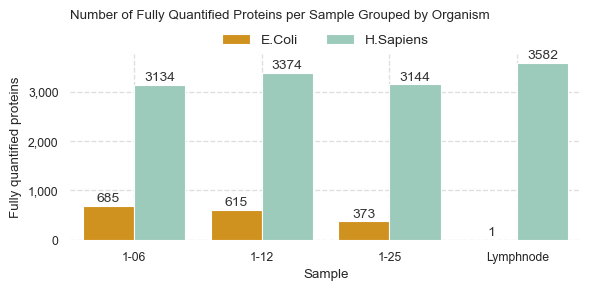

In [11]:
# Number of proteins fully quantified in each condition
is_quant = pd.DataFrame(index=data.index)
for c, s in samp_col.items():
    is_quant[c] = data[s].isna().sum(axis=1) == 0

plot_data = is_quant.reset_index().melt(
    id_vars="index",
    var_name="Sample",
    value_name="Fully quantified",
).rename(columns={"index": "Entry"})
plot_data["Organism"] = plot_data["Entry"].map(org_map)
plot_data = plot_data.groupby(["Organism", "Sample"]).sum()

# Initialize the figure and axes
fig, ax = plt.subplots(figsize=(6, 3))
# Facet by Sample
sns.barplot(
    data=plot_data.reset_index(),
    x="Sample",
    y="Fully quantified",
    hue="Organism",
    ax=ax,
    dodge=True,
    palette=organism_colors,
    order=sample_order
)
# Add counts on top of the bars
for p in ax.patches:
    ax.annotate(
        format(p.get_height(), ".0f"),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 5),
        textcoords="offset points",
        fontsize=10,
        color="#333533",
    )

# Axis ticks
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
# Set the axis labels
ax.set_xlabel("Sample")
ax.set_ylabel("Fully quantified proteins")
ax.set_title(
    "Number of Fully Quantified Proteins per Sample Grouped by Organism", 
    loc="left",
    pad=25,
)

# Grid
ax.grid(
    axis="both",
    which="major",
    color="lightgrey",
    linestyle="--",
    linewidth=.95,
    alpha=0.75,
)

# Legend with 2col and no frame and on top
ax.legend(
    ncol=2,
    frameon=False,
    bbox_to_anchor=(0.5, 1.175),
    loc="upper center",
    prop={"size": 10},
)

sns.despine(
    left=True,
    bottom=True,
)
plt.tight_layout()

# Save the figure, if save_to_folder is True
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = "InitialState_FullyQuantifiedProteins_GroupedBar",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

The number of fully quantified proteins is lower than expected given the total protein count in the data (around 6800), as even a single missing replicate out of the 23 per sample would exclude it from the count. While the data looks fine so far, this issue must be addressed through imputation to minimize the need to discard proteins during the testing phase.

## Boxplot of Samples

A boxplot was created to visualize the distribution of average protein intensities for samples grouped by organism. This allowed for an examination of how the organism was quantified.

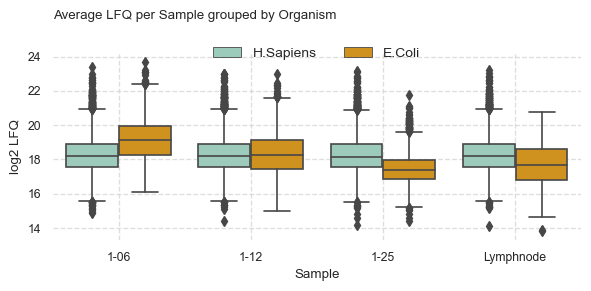

In [12]:
# Create an average of the 23 replicates
average_data = pd.DataFrame()
for c, s in samp_col.items():
    average_data[c] = data[s].mean(axis=1)

plot_data = average_data.reset_index().melt(
    id_vars="index",
    var_name="Sample", 
    value_name="LFQ"
).rename(columns={"index": "Entry"})
plot_data["Organism"] = plot_data["Entry"].map(org_map)
plot_data["log2 LFQ"] = np.log2(plot_data["LFQ"])
plot_data.head()

# Initialize the figure and axes
fig, ax = plt.subplots(figsize=(6, 3))
# Facet by Sample
sns.boxplot(
    data=plot_data,
    x="Sample",
    y="log2 LFQ",
    hue="Organism",
    palette=organism_colors,
    ax=ax,
    order = sample_order
)

# Set the axis labels
ax.set_xlabel("Sample")
ax.set_ylabel("log2 LFQ")
ax.set_title(
    "Average LFQ per Sample grouped by Organism", 
    loc="left",
    pad=25,
)

# Grid
ax.grid(
    axis="both",
    which="major",
    color="lightgrey",
    linestyle="--",
    linewidth=.95,
    alpha=0.75,
)

# Legend with 2col and no frame and on top
ax.legend(
    ncol=2,
    frameon=False,
    bbox_to_anchor=(0.5, 1.10),
    loc="upper center",
    prop={"size": 10},
)

sns.despine(
    left=True,
    bottom=True,
)
plt.tight_layout()

# Save the figure, if save_to_folder is True
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = "InitialState_AverageLFQ_GroupedBox",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

The quantification of human proteins in all samples shows a similar distribution, while the quantification levels of E.coli proteins vary in each sample as expected. The 1-06 sample exhibits the highest E.coli protein quantification levels, while the 1-25 sample has the lowest levels. However, there is an issue with identifying E.coli proteins in the Lymphnode sample, which should be corrected and not be present.

# Data Processing

Overall, there are a few things to address in the data. However, I will be making two further improvements to polish the data. Firstly, I will introduce a cleanup step to remove proteins with sparse quantification and impute missing values for proteins with sparse data. Secondly, I will remove only fully quantified proteins in one sample. These proteins are not helpful in the testing phase as they are specific to one group and will be dropped during testing anyway.

> **Note 1:** I will not remove the E.coli proteins from the Lymphnode sample. This is to demonstrate in the testing phase whether our method can accurately identify misidentified proteins that match other E.coli spiked-in samples and show the expected difference levels.

> **Note 2:** The imputation I will use will replace missing values with the median value of a protein. However, I will not impute everything; I will only use it to boost the number of fully quantified proteins. I want to avoid dealing with unequal sample sizes and the potential loss of reliably quantified proteins. However, users can introduce their own imputation method if they want to impute everything.

## Clean and Impute the Data

I performed a simple cleanup since the data had no apparent issues at first glance. I removed mostly missing proteins and imputed proteins with sparse missing values by using the mean of the protein for that sample. If a protein was quantified more than 75% within a cell line, the remaining values were replaced with the mean value for that protein in that specific sample. However, if a protein was quantified in less than 20% of samples per cell line, the quantified sample was cleaned to NaN, allowing it to be placed at a low value using downshifted imputation if desired. I did not impute all the missing values for any analysis conducted in this manuscript. However, I am keeping this as an option if imputation is desired.

In [13]:
# Cleaning the quantification data for more robust analysis
avg_thr = 1 - 0.75
miss_thresh = 1 - 0.20

print("Cleaning the Quantification Data with the following criteria:")
print("  - Fill with Average if Missing Percentage is < {}".format(avg_thr))
print("  - Set to all to NaN if Missing Percentage is > {}".format(miss_thresh))
print("-" * 50)
print(
    "Number of Fully Retained Proteins Before Cleaning, {}".format(
        data.dropna().shape[0]
    )
)
res_lst = []
cur_features = data.index

# Loop through the samples
for c, cols in samp_col.items():
    # Subset for the specific condition
    con_sub_data = data[cols].values
    # Calculate the missing percentage
    miss_col_cnt = np.isnan(con_sub_data).sum(axis=1)
    miss_col_pct = (miss_col_cnt / len(cols))
    # Find indexes where NaN will be filled with the average
    fillwithAvg_idx = np.where(
        (miss_col_pct <= avg_thr) & 
        (miss_col_cnt != 0)
    )[0]
    # Find the mean value for fillwithAvg_idx
    avgProts = np.nanmean(
        con_sub_data[fillwithAvg_idx], axis=1
    )
    # Find indexes where all values will be NaN
    allNaN_idx = np.where(
        (miss_col_pct >= miss_thresh) & 
        (miss_col_cnt != 1)
    )[0]
    # Find indices to keep as is
    keepAs_idx = np.array(list(
        set(range(len(cur_features))) - 
        (
            set(fillwithAvg_idx) | 
            set(allNaN_idx)
        )
    ))
    # Fill NaN with average
    for i in range(len(fillwithAvg_idx)):
        con_sub_data[fillwithAvg_idx[i]] = np.nan_to_num(
            con_sub_data[fillwithAvg_idx[i]], 
            nan=avgProts[i]
        )
    # Set NaN
    for i in range(len(allNaN_idx)):
        con_sub_data[allNaN_idx[i]] = np.nan
    # Create a dataframe from the subsetted data
    con_sub_data_df = pd.DataFrame(
        con_sub_data, 
        index=cur_features, 
        columns=cols
    )
    # Append the dataframe to the list
    res_lst.append(con_sub_data_df)

# Concatenate the list of dataframes
clean_data = pd.concat(res_lst, axis=1)

print(
    "Number of Fully Retained Proteins After Cleaning, {}".format(
        clean_data.dropna().shape[0]
    )
)

Cleaning the Quantification Data with the following criteria:
  - Fill with Average if Missing Percentage is < 0.25
  - Set to all to NaN if Missing Percentage is > 0.8
--------------------------------------------------
Number of Fully Retained Proteins Before Cleaning, 2656
Number of Fully Retained Proteins After Cleaning, 4252


If less than 6 replicates are missing for a protein in a given sample, replace them with the mean of the protein in that sample. If more than 17 replicates are missing for a protein in a given sample, replace them with NaN so they can be imputed if desired.

After this simple clean-up, fully quantified proteins increased from 2656 to 4252.

## Remove Proteins Not Fully Quantified in at Least Two Samples

For the upcoming testing and analysis, I want to use only the fully quantified proteins in every sample. This ensures that no bias is introduced by having unequal sample sizes in the results. Therefore, I remove proteins that are only fully quantified in a single sample at this step. This may remove proteins from the 1-06 sample, as it typically has a higher number of E.coli proteins quantified compared to other spiked samples. However, these distinctly quantified proteins won't be useful in the testing or any other analysis except for comparing the quantification numbers.

In [14]:
# Select the data to run (imputed or centered)
data2run = clean_data.copy()
# Create a dataframe to check the completeness of the data
check_data = (~data2run.isna())
cur_lst = []

for c, s in samp_col.items():
    cur_lst.append(check_data.loc[:, s].sum(axis=1))

check_data = pd.DataFrame(cur_lst, index=samp_col.keys()).T

# Find proteins that are quantified in at least 2 cell lines
nrep = 23
proteins2keep = check_data[(check_data == nrep).sum(axis=1) >= 2].index
print("Total number before:", data2run.shape[0])
print("Number of proteins quantified in at least 2 cell lines:", len(proteins2keep))
# Update the data to run
data2run = data2run.loc[proteins2keep]

Total number before: 6802
Number of proteins quantified in at least 2 cell lines: 5389


This reduces the total number of proteins quite a bit. However, for my analysis, the dropped proteins are not useful and only increase the number of proteins excluded from the tests.

## Look at the Data after the Cleanup

After performing the cleanup steps, I visualized the data again using the same plots to observe how the changes affected the data.

### Density of Replicates

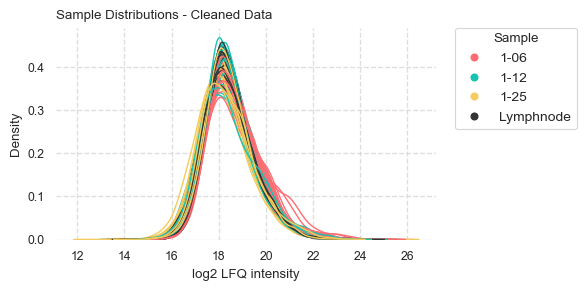

In [15]:
fig, ax = plt.subplots(figsize=(6, 3))
for s, g in col_samp.items():
    sns.kdeplot(
        data=np.log2(data2run[s]),
        ax=ax,
        color=sample_labels[g],
        linewidth=1,
        fill=False,
        label=None,
    )
ax.set_xlabel("log2 LFQ intensity")
ax.set_ylabel("Density")
ax.set_title("Sample Distributions - Cleaned Data", loc="left")
# Create a legend
handles = [
    plt.Line2D(
        [], [],
        color=cl,
        marker="o",
        linestyle="",
        label=ts,
    ) for ts, cl in sample_labels.items()
]
ax.legend(
    handles=handles,
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0,
    title="Sample",
    prop={"size": 10},
)
# Add grid
ax.grid(
    axis="both",
    which="major",
    color="lightgrey",
    linestyle="--",
    linewidth=.95,
    alpha=0.75,
)

sns.despine(
    left=True,
    bottom=True,
)
plt.tight_layout()

# Save the figure, if save_to_folder is True
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = "CleanedState_ReplicateDistributions",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

After cleaning, there appears to be an increased grouping of the same replicates. For example, the yellow lines (sample 1-25) and pink lines (sample 1-06) are now more closely grouped together compared to the initial state.

### Intra-sample Coefficient of Variation

Intra-CV(%) of each sample (23 replicates)
Median
 1-06 -> 23.215
 1-12 -> 23.757
 1-25 -> 23.379
 Lymphnode -> 19.896
---------------
Mean
 1-06 -> 27.794
 1-12 -> 27.094
 1-25 -> 28.797
 Lymphnode -> 24.811


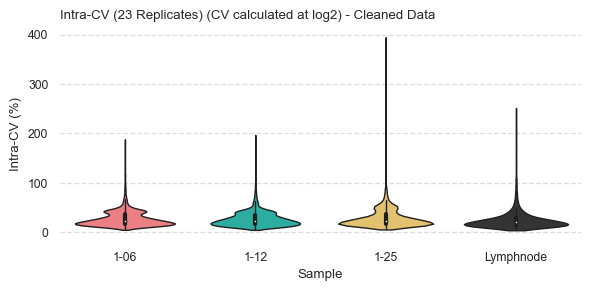

In [16]:
intra_cv = pd.DataFrame()
for c, s in samp_col.items():
    cur_data = data2run[s]
    intra_cv[c] = cur_data[s].std(axis=1) / cur_data[s].mean(axis=1) * 100

# Initialize the figure
fig, ax = plt.subplots(figsize=(6, 3))
# Plot the data
sns.violinplot(
    data=intra_cv,
    palette=sample_labels,
    ax=ax,
    linewidth=1,
    cut=0,
    order = sample_order,
)
# Set the axis labels
ax.set_xlabel("Sample")
ax.set_ylabel("Intra-CV (%)")
ax.set_title("Intra-CV (23 Replicates) (CV calculated at log2) - Cleaned Data", loc="left")
# Grid
ax.grid(
    axis="y",
    which="major",
    color="lightgrey",
    linestyle="--",
    linewidth=.95,
    alpha=0.75,
)
sns.despine(
    left=True,
    bottom=True,
)
plt.tight_layout()

# Save the figure, if save_to_folder is True
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = "CleanedState_IntraCV_Violin",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

print("Intra-CV(%) of each sample (23 replicates)")
utils.print_series(
    series = intra_cv.median().round(3),
    header = "Median"
)
print("-"*15)
utils.print_series(
    series = intra_cv.mean().round(3),
    header = "Mean"
)

After the cleanup steps, the violin plots representing the intra-sample coefficient of variation show that the distribution of CV values for the spiked-in samples appears to be sharper at lower values. This suggests an improvement in the reproducibility of the samples. Additionally, there is a slight improvement in the mean and median CV values across the samples.

### Quantified Protein Counts

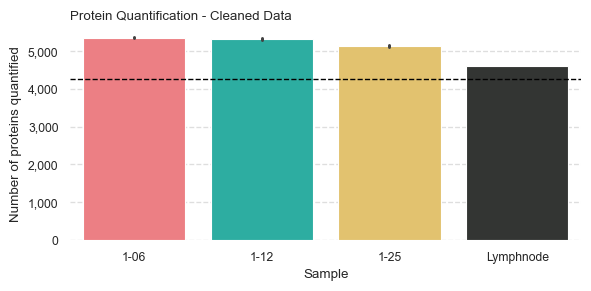

In [17]:
plot_data = data2run.isna().sum().to_frame().rename(columns={0: "NA"})
plot_data["Quantified"] = data2run.shape[0] - plot_data["NA"]
plot_data["Sample"] = plot_data.index.map(col_samp)
plot_data = plot_data.sort_values(["Sample", "Quantified"])
# Initialize the figure and axes
fig, ax = plt.subplots(figsize=(6, 3))
# Facet by Sample
sns.barplot(
    data=plot_data,
    x="Sample",
    y="Quantified",
    hue="Sample",
    palette=sample_labels,
    ax=ax,
    dodge=False,
)
# Add fully quantified 
fulqn = data2run.dropna().shape[0]
ax.axhline(
    y=fulqn,
    color="black",
    linestyle="--",
    linewidth=1,
    label="Fully quantified",
)

# Axis ticks
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
# Set the axis labels
ax.set_xlabel("Sample")
ax.set_ylabel("Number of proteins quantified")
ax.set_title("Protein Quantification - Cleaned Data", loc="left")

# Grid
ax.grid(
    axis="y",
    which="major",
    color="lightgrey",
    linestyle="--",
    linewidth=.95,
    alpha=0.75,
)
# Remove legend
ax.legend().remove()

sns.despine(
    left=True,
    bottom=True,
)
plt.tight_layout()

# Save the figure, if save_to_folder is True
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = "CleanedState_ProteinQuantification_Bar",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

Both 1-06 and 1-12 have the same number of quantified proteins after the cleanup. Additionally, we can observe that the black dashed line, which represents the fully quantified protein count in all samples, is higher than before. This increase is attributed to the imputation of missing values. Furthermore, it is evident that the number of quantified proteins in the Lymphnode sample is almost identical to the fully quantified protein count in all samples.

### Fully Quantified Proteins per Condition+Organism

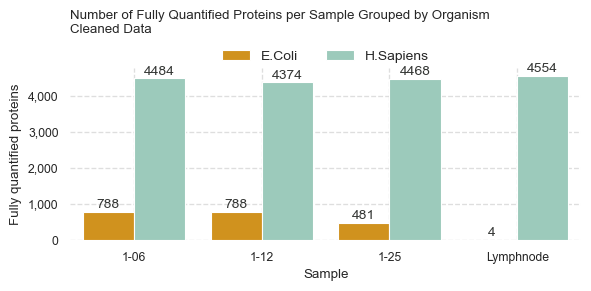

In [18]:
# Number of proteins fully quantified in each condition
is_quant = pd.DataFrame(index=data2run.index)
for c, s in samp_col.items():
    is_quant[c] = data2run[s].isna().sum(axis=1) == 0

plot_data = is_quant.reset_index().melt(
    id_vars="index",
    var_name="Sample",
    value_name="Fully quantified",
).rename(columns={"index": "Entry"})
plot_data["Organism"] = plot_data["Entry"].map(org_map)
plot_data = plot_data.groupby(["Organism", "Sample"]).sum()

# Initialize the figure and axes
fig, ax = plt.subplots(figsize=(6, 3))
# Facet by Sample
sns.barplot(
    data=plot_data.reset_index(),
    x="Sample",
    y="Fully quantified",
    hue="Organism",
    ax=ax,
    dodge=True,
    palette=organism_colors,
    order = sample_order
)
# Add counts on top of the bars
for p in ax.patches:
    ax.annotate(
        format(p.get_height(), ".0f"),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 5),
        textcoords="offset points",
        fontsize=10,
        color="#333533",
    )

# Axis ticks
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
# Set the axis labels
ax.set_xlabel("Sample")
ax.set_ylabel("Fully quantified proteins")
ax.set_title(
    "Number of Fully Quantified Proteins per Sample Grouped by Organism\nCleaned Data",
    loc="left",
    pad=25,
)

# Grid
ax.grid(
    axis="both",
    which="major",
    color="lightgrey",
    linestyle="--",
    linewidth=.95,
    alpha=0.75,
)

# Legend with 2col and no frame and on top
ax.legend(
    ncol=2,
    frameon=False,
    bbox_to_anchor=(0.5, 1.175),
    loc="upper center",
    prop={"size": 10},
)

sns.despine(
    left=True,
    bottom=True,
)
plt.tight_layout()

# Save the figure, if save_to_folder is True
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = "CleanedState_FullyQuantifiedProteins_GroupedBar",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

Looking at the fully quantified bar plot again, we can observe the effects of the cleanup. The E.coli numbers in the 1-06 sample have been reduced to the same level as the 1-12 sample.

### Boxplot of Samples

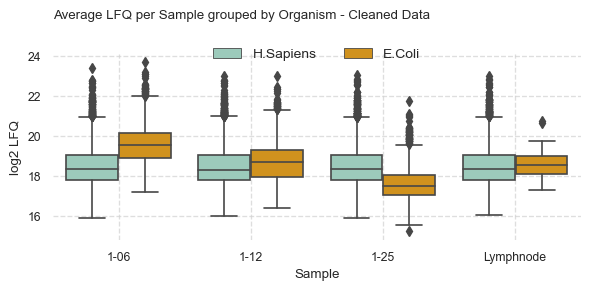

In [19]:
# Create an average of the 23 replicates
average_data = pd.DataFrame()
for c, s in samp_col.items():
    average_data[c] = data2run[s].mean(axis=1)
plot_data = average_data.reset_index().melt(
    id_vars="index",
    var_name="Sample", 
    value_name="LFQ"
).rename(columns={"index": "Entry"})
plot_data["Organism"] = plot_data["Entry"].map(org_map)
plot_data["log2 LFQ"] = np.log2(plot_data["LFQ"])
plot_data.head()

# Initialize the figure and axes
fig, ax = plt.subplots(figsize=(6, 3))
# Facet by Sample
sns.boxplot(
    data=plot_data,
    x="Sample",
    y="log2 LFQ",
    hue="Organism",
    palette=organism_colors,
    ax=ax,
    order = sample_order
)

# Set the axis labels
ax.set_xlabel("Sample")
ax.set_ylabel("log2 LFQ")
ax.set_title(
    "Average LFQ per Sample grouped by Organism - Cleaned Data", 
    loc="left",
    pad=25,
)

# Grid
ax.grid(
    axis="both",
    which="major",
    color="lightgrey",
    linestyle="--",
    linewidth=.95,
    alpha=0.75,
)

# Legend with 2col and no frame and on top
ax.legend(
    ncol=2,
    frameon=False,
    bbox_to_anchor=(0.5, 1.10),
    loc="upper center",
    prop={"size": 10},
)

sns.despine(
    left=True,
    bottom=True,
)
plt.tight_layout()

# Save the figure, if save_to_folder is True
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = "CleanedState_AverageLFQ_GroupedBox",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

# Sample Comparison

A scatter plot, similar to an MA plot, is used to visualize the difference in protein intensities between different samples of organisms. For example, when comparing samples 1-06 and 1-25, if more E.coli peptides were prepared in 1-06, we can observe an increase in E.coli intensity of approximately 2 log2 fold. This difference is expected. The scatter plots help us determine if the samples can capture this difference. As for human proteins, since they are not likely to change, we anticipate their intensities to remain around 0 log2 fold change.

## 1-06 vs 1-25

This is the comparison with the largest expected difference in E.Coli protein intensities. In sample 1-06, 1 E.coli peptide is prepared per 6 human peptides, while in sample 1-25, 1 E.coli peptide is prepared per 25 human peptides. Therefore, I anticipate an approximate 2.1 log2 fold difference in E.coli protein intensities.

The plot used in this analysis is a scatter plot. The x-axis represents the average protein intensity in S2, which is sample 1-25, using a log2 scale. The y-axis represents the log2 fold-change calculated with S1.S2. The proteins are colour-coded based on their organism. The dashed line, with colours corresponding to the organism, represents the 0 log2 fold-change for Humans and the 2.1 log2 fold-change for E.coli. Additionally, a boxplot is added to visualize the distribution of proteins along the y-axis and to determine if the organism's boxplot is centred around the expected log2 fold change.

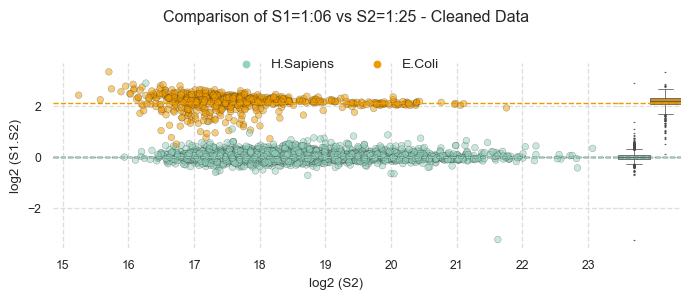

In [20]:
# Create a data for scatter plot of Ecoli vs human proteins in 2 samples compared
plot_data = pd.DataFrame(index=data2run.index)
plot_data["organism"] = plot_data.index.map(org_map)
elfc_ecoli = 2.1
elfc_human = 0.0
plot_data["S1"] = data2run[samp_col["1-06"]].mean(axis=1)
plot_data["S2"] = data2run[samp_col["1-25"]].mean(axis=1)
plot_data["log2 S1"] = np.log2(plot_data["S1"])
plot_data["log2 S2"] = np.log2(plot_data["S2"])
plot_data["log2 (S1.S2)"] = plot_data["log2 S1"] - plot_data["log2 S2"]
plot_data["log2 (S1.S2)"] = plot_data["log2 (S1.S2)"].replace(-np.inf, np.nan)


# Initialize the figure and axes
fig, ax = plt.subplots(
    figsize=(7, 3),
    ncols=2,
    nrows=1,
    sharey=True,
    sharex=False,
    gridspec_kw={
        "width_ratios": [0.9, 0.1], 
        "wspace": 0.0
    },

)

# Plot a scatter plot
sns.scatterplot(
    ax=ax[0],
    data=plot_data,
    x="log2 S2",
    y="log2 (S1.S2)",
    hue="organism",
    palette=organism_colors,
    edgecolor='k',
    linewidth=0.25,
    alpha=0.5,
    rasterized=True,
)

# Set the axis labels
ax[0].set_xlabel("log2 (S2)")
ax[0].set_ylabel("log2 (S1.S2)")

# Grid
ax[0].grid(
    axis="both",
    which="major",
    color="lightgrey",
    linestyle="--",
    linewidth=.95,
    alpha=0.75,
)

# Legend with 2col and no frame and on top
ax[0].legend(
    ncol=2,
    frameon=False,
    bbox_to_anchor=(0.5, 1.10),
    loc="upper center",
    prop={"size": 10},
)

# Boxplot of the log2 (S1.S2)
sns.boxplot(
    ax=ax[1],
    data=plot_data,
    x="organism",
    y="log2 (S1.S2)",
    palette=organism_colors,
    linewidth=0.5,
    width=1,
    fliersize=0.25,
    order=organism_colors.keys(),
    
)

# Remove the x- and y-axis labels for the boxplot
ax[1].set_xlabel("")
ax[1].set_ylabel("")
# Remove x-ticks
ax[1].set_xticks([])

# Add a horizontal line at 0 ax[0] and ax[1]
ax[0].axhline(
    y=0,
    color="black",
    linestyle="--",
    linewidth=1,
)
ax[1].axhline(
    y=0,
    color="black",
    linestyle="--",
    linewidth=1,
)

# Add horizontal lines at elfc_ecoli and elfc_human
for i in range(2):
    ax[i].axhline(
        y=elfc_ecoli,
        color='#ee9b00',
        linestyle="--",
        linewidth=1,
    )
    ax[i].axhline(
        y=elfc_human,
        color='#94d2bd',
        linestyle="--",
        linewidth=1,
    )

# Add a vertical line at 0

# Grid
ax[1].grid(
    axis="both",
    which="major",
    color="lightgrey",
    linestyle="--",
    linewidth=.95,
    alpha=0.75,
)

fig.suptitle(
    "Comparison of S1=1:06 vs S2=1:25 - Cleaned Data",
)

sns.despine(
    left=True,
    bottom=True,
)
plt.tight_layout()

# Save the figure, if save_to_folder is True
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = "CleanedState_1-06vs1-25_Scatter",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

As expected, although slightly higher, most E.coli proteins are centred around a 2.1 log2 fold-change. On the other hand, Human proteins are centred around a 0 log2 fold-change. However, large outliers are also present in both E.coli and Human proteins.

## 1-06 vs 1-12

This is a comparison with a 1 log2 fold difference expected in E. Coli protein intensities. In 1-06, 1 E. Coli peptide is prepared per 6 human peptides, while in 1-12, 1 E. Coli peptide is prepared per 12 human peptides. Therefore, we anticipate observing an approximate 1 log2 fold difference in E. Coli protein intensities.

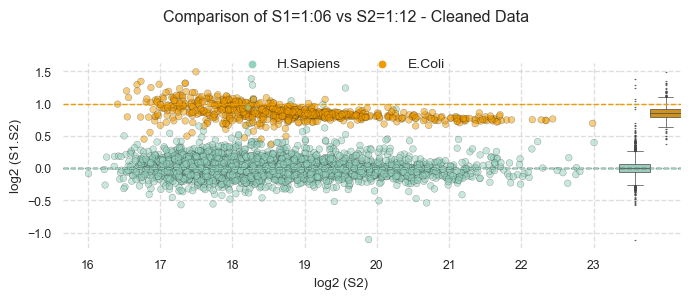

In [21]:
# Create a data for scatter plot of Ecoli vs human proteins in 2 samples compared
plot_data = pd.DataFrame(index=data2run.index)
plot_data["organism"] = plot_data.index.map(org_map)
elfc_ecoli = 1.0
elfc_human = 0.0
plot_data["S1"] = data2run[samp_col["1-06"]].mean(axis=1)
plot_data["S2"] = data2run[samp_col["1-12"]].mean(axis=1)
plot_data["log2 S1"] = np.log2(plot_data["S1"])
plot_data["log2 S2"] = np.log2(plot_data["S2"])
plot_data["log2 (S1.S2)"] = plot_data["log2 S1"] - plot_data["log2 S2"]
plot_data["log2 (S1.S2)"] = plot_data["log2 (S1.S2)"].replace(-np.inf, np.nan)


# Initialize the figure and axes
fig, ax = plt.subplots(
    figsize=(7, 3),
    ncols=2,
    nrows=1,
    sharey=True,
    sharex=False,
    gridspec_kw={
        "width_ratios": [0.9, 0.1], 
        "wspace": 0.0
    },

)

# Plot a scatter plot
sns.scatterplot(
    ax=ax[0],
    data=plot_data,
    x="log2 S2",
    y="log2 (S1.S2)",
    hue="organism",
    palette=organism_colors,
    edgecolor='k',
    linewidth=0.25,
    alpha=0.5,
    rasterized=True,
)

# Set the axis labels
ax[0].set_xlabel("log2 (S2)")
ax[0].set_ylabel("log2 (S1.S2)")

# Grid
ax[0].grid(
    axis="both",
    which="major",
    color="lightgrey",
    linestyle="--",
    linewidth=.95,
    alpha=0.75,
)

# Legend with 2col and no frame and on top
ax[0].legend(
    ncol=2,
    frameon=False,
    bbox_to_anchor=(0.5, 1.10),
    loc="upper center",
    prop={"size": 10},
)

# Boxplot of the log2 (S1.S2)
sns.boxplot(
    ax=ax[1],
    data=plot_data,
    x="organism",
    y="log2 (S1.S2)",
    palette=organism_colors,
    linewidth=0.5,
    width=1,
    fliersize=0.25,
    order=organism_colors.keys(),
    
)

# Remove the x- and y-axis labels for the boxplot
ax[1].set_xlabel("")
ax[1].set_ylabel("")
# Remove x-ticks
ax[1].set_xticks([])

# Add a horizontal line at 0 ax[0] and ax[1]
ax[0].axhline(
    y=0,
    color="black",
    linestyle="--",
    linewidth=1,
)
ax[1].axhline(
    y=0,
    color="black",
    linestyle="--",
    linewidth=1,
)

# Add horizontal lines at elfc_ecoli and elfc_human
for i in range(2):
    ax[i].axhline(
        y=elfc_ecoli,
        color='#ee9b00',
        linestyle="--",
        linewidth=1,
    )
    ax[i].axhline(
        y=elfc_human,
        color='#94d2bd',
        linestyle="--",
        linewidth=1,
    )

# Add a vertical line at 0

# Grid
ax[1].grid(
    axis="both",
    which="major",
    color="lightgrey",
    linestyle="--",
    linewidth=.95,
    alpha=0.75,
)

fig.suptitle(
    "Comparison of S1=1:06 vs S2=1:12 - Cleaned Data",
)

sns.despine(
    left=True,
    bottom=True,
)
plt.tight_layout()

# Save the figure, if save_to_folder is True
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = "CleanedState_1-06vs1-12_Scatter",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

The same plot compares samples with organism information represented as the hue. While human proteins are mostly centred around a 0 log2 fold-change, the E.coli proteins, especially the ones with higher intensity, deviate from the expected 1 log2 fold-change to show more minor differences. This could be due to search engine-related factors or artifacts from the imputation process we conducted. Although this is not ideal, it is not a major issue, and the QuestVar framework is robust enough to handle it if the boundaries are set appropriately.

## 1-06 vs Lympnode

This comparison is between a sample with E.coli proteins injected at the highest concentration (1:6) and one with no E.coli proteins injected (the original).

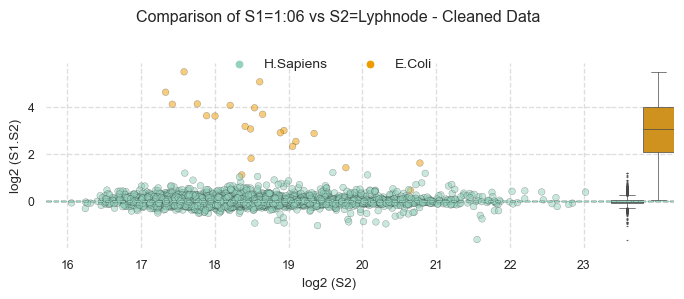

In [22]:
# Create a data for scatter plot of Ecoli vs human proteins in 2 samples compared
plot_data = pd.DataFrame(index=data2run.index)
plot_data["organism"] = plot_data.index.map(org_map)
# elfc_ecoli = 1.0
elfc_human = 0.0
plot_data["S1"] = data2run[samp_col["1-06"]].mean(axis=1)
plot_data["S2"] = data2run[samp_col["Lymphnode"]].mean(axis=1)
plot_data["log2 S1"] = np.log2(plot_data["S1"])
plot_data["log2 S2"] = np.log2(plot_data["S2"])
plot_data["log2 (S1.S2)"] = plot_data["log2 S1"] - plot_data["log2 S2"]
plot_data["log2 (S1.S2)"] = plot_data["log2 (S1.S2)"].replace(-np.inf, np.nan)


# Initialize the figure and axes
fig, ax = plt.subplots(
    figsize=(7, 3),
    ncols=2,
    nrows=1,
    sharey=True,
    sharex=False,
    gridspec_kw={
        "width_ratios": [0.9, 0.1], 
        "wspace": 0.0
    },

)

# Plot a scatter plot
sns.scatterplot(
    ax=ax[0],
    data=plot_data,
    x="log2 S2",
    y="log2 (S1.S2)",
    hue="organism",
    palette=organism_colors,
    edgecolor='k',
    linewidth=0.25,
    alpha=0.5,
    rasterized=True,
)

# Set the axis labels
ax[0].set_xlabel("log2 (S2)")
ax[0].set_ylabel("log2 (S1.S2)")

# Grid
ax[0].grid(
    axis="both",
    which="major",
    color="lightgrey",
    linestyle="--",
    linewidth=.95,
    alpha=0.75,
)

# Legend with 2col and no frame and on top
ax[0].legend(
    ncol=2,
    frameon=False,
    bbox_to_anchor=(0.5, 1.10),
    loc="upper center",
    prop={"size": 10},
)

# Boxplot of the log2 (S1.S2)
sns.boxplot(
    ax=ax[1],
    data=plot_data,
    x="organism",
    y="log2 (S1.S2)",
    palette=organism_colors,
    linewidth=0.5,
    width=1,
    fliersize=0.25,
    order=organism_colors.keys(),
    
)

# Remove the x- and y-axis labels for the boxplot
ax[1].set_xlabel("")
ax[1].set_ylabel("")
# Remove x-ticks
ax[1].set_xticks([])

# Add a horizontal line at 0 ax[0] and ax[1]
ax[0].axhline(
    y=0,
    color="black",
    linestyle="--",
    linewidth=1,
)
ax[1].axhline(
    y=0,
    color="black",
    linestyle="--",
    linewidth=1,
)

# Add horizontal lines at elfc_ecoli and elfc_human
for i in range(2):
    # ax[i].axhline(
    #     y=elfc_ecoli,
    #     color='#ee9b00',
    #     linestyle="--",
    #     linewidth=1,
    # )
    ax[i].axhline(
        y=elfc_human,
        color='#94d2bd',
        linestyle="--",
        linewidth=1,
    )

# Add a vertical line at 0

# Grid
ax[1].grid(
    axis="both",
    which="major",
    color="lightgrey",
    linestyle="--",
    linewidth=.95,
    alpha=0.75,
)

fig.suptitle(
    "Comparison of S1=1:06 vs S2=Lyphnode - Cleaned Data",
)

sns.despine(
    left=True,
    bottom=True,
)
plt.tight_layout()

# Save the figure, if save_to_folder is True
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = "CleanedState_1-06vsLymphnode_Scatter",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

I expected to see no E.coli proteins in the latter sample; however, there are still several E.coli proteins visible between the two. This discrepancy is again due to mislabeling the peptides used to quantify the proteins. Nevertheless, the number of mislabeled proteins is negligible and can be ignored. The remaining human proteins, as expected, are centred around a 0 log2 fold-change with some outliers, while the E.coli proteins show a wide range of fold-changes.

# Saving the Data

After completing the quality checks and necessary processing, I save the following data in the `.feather` format to be used in the testing phase of the following notebook. These data are stored in the `data/processed/` folder.

## Metadata Used

The metadata used in this notebook is a simple table containing the sample names and the corresponding sample groups saved as `metadata.feather` in the `data/processed/` folder.

In [23]:
feather.write_dataframe(
    df=metadata, 
    dest=output_path+"metadata.feather"
)
print("Metadata saved to {}".format(output_path+"metadata.feather"))
print(metadata.shape)
metadata.head()

Metadata saved to ./data/processed/metadata.feather
(92, 2)


,columnName,Sample
0,Lymph_043,Lymphnode
1,Lymph_Ecoli_1-12_092,1-12
2,Lymph_Ecoli_1-25_102,1-25
3,Lymph_Ecoli_1-12_022,1-12
4,Lymph_Ecoli_1-6_053,1-06


## Cleaned Quant Data

The cleaned and processed protein-level quantitative data is saved as `clean_quantdata.feather` in the `data/processed/` folder. This data is saved as a reference if further analysis needs the complete data without subsets. 

In [24]:
feather.write_dataframe(
    df=data2run, 
    dest=output_path+"clean_quantdata.feather"
)
print("Cleaned quantification data saved to {}".format(output_path+"clean_quantdata.feather"))
print(data2run.shape)
data2run.head()

Cleaned quantification data saved to ./data/processed/clean_quantdata.feather
(5389, 92)


,Lymph_Ecoli_1-6_053,Lymph_Ecoli_1-6_072,Lymph_Ecoli_1-6_094,Lymph_Ecoli_1-6_042,Lymph_Ecoli_1-6_070,Lymph_Ecoli_1-6_071,Lymph_Ecoli_1-6_106,Lymph_Ecoli_1-6_026,Lymph_Ecoli_1-6_093,Lymph_Ecoli_1-6_011,Lymph_Ecoli_1-6_096,Lymph_Ecoli_1-6_028,...,Lymph_0100,Lymph_016,Lymph_058,Lymph_130,Lymph_044,Lymph_057,Lymph_077,Lymph_004,Lymph_031,Lymph_098,Lymph_076,Lymph_017
Q86U42,506318.9739,543113.2487,445348.6625,508487.2738,511737.1955,571885.0932,507285.1472,492400.1750,392216.8403,627397.2261,512410.4286,1455567.5790,...,554057.6502,515334.8035,607775.4674,561748.8081,802583.0465,547026.0600,432514.4137,538153.6472,500107.2297,570861.2686,555498.0765,587342.2682
P37108,898993.1767,926475.0344,779352.4682,915210.0106,949845.1089,1083606.0889,541074.8500,740986.9593,751875.6986,784325.9671,838760.0197,1243387.3695,...,608046.1271,691973.2903,817296.6938,720602.7899,802355.3559,784262.1698,842867.0247,712700.0197,788259.0483,672281.2089,869739.9696,798300.1133
Q96JP5,361407.6293,390284.0107,420619.5788,399276.8189,393757.0148,337906.0935,246724.4268,401921.3447,278077.6930,371504.2974,387909.7707,823581.1740,...,176676.1086,284915.8077,292004.7854,318794.3648,382281.6197,399869.6187,333072.2563,294706.7049,278177.9803,272033.3245,241468.5557,296003.5736
Q8N697,920834.0000,612875.0000,463855.0000,387322.0000,707871.0000,443971.0000,427263.0000,529735.9524,413949.0000,529735.9524,428282.0000,509009.0000,...,381698.0000,166849.0000,327617.0000,385047.0000,329377.0000,545227.0000,602538.0000,471052.0000,523377.0000,453288.0000,391330.0000,225459.0000
O75822,503476.2175,457396.3332,539600.7011,461392.5282,454764.2379,511720.6153,428131.0396,551994.1797,435108.4593,560902.3976,510640.3993,1080424.2962,...,427443.9458,479388.1827,464301.1289,514986.5404,421639.8487,458992.3746,461546.9346,483984.2490,440175.3291,518179.5013,609592.9940,469434.4712


## Protein Information

This contains the fasta information of the proteins in the data that will be used. The file name is `protein_info_data.feather`.

In [25]:
allProteins = data2run.index.tolist()
protein_info = protein_info[protein_info["entry"].isin(allProteins)].reset_index(drop=True)
# Save as feather
feather.write_dataframe(
    protein_info,
    dest = output_path+"protein_info_data.feather"   
)
print("Protein info saved to {}".format(output_path+"protein_info_data.feather"))
print(protein_info.shape)
protein_info.head()

Protein info saved to ./data/processed/protein_info_data.feather
(5389, 5)


,entry,entryName,geneName,sequenceLength,organism
0,A0A075B6H9,LV469_HUMAN,IGLV4-69,119,H.Sapiens
1,A0A075B6I9,LV746_HUMAN,IGLV7-46,117,H.Sapiens
2,A0A075B6K4,LV310_HUMAN,IGLV3-10,115,H.Sapiens
3,A0A075B6R9,KVD24_HUMAN,IGKV2D-24,120,H.Sapiens
4,A0A0A0MS15,HV349_HUMAN,IGHV3-49,119,H.Sapiens


## Create Sample Subset Data

Each sample is subsetted into a separate file and saved in the `data/processed/samples/` folder. This is done to make the testing process easier and faster. The subset files are named `sampleName.feather` and contain only the protein-level quant data for that sample.

In [26]:
n = 1
for c, s in samp_col.items():
    cur_subset = data2run[s]
    # Save the data to a feather file
    feather.write_dataframe(
        cur_subset, 
        quant_path + c + ".feather"
    )
    n += 1
    
print("Number of subset files saved:", n)
print("All subsetted data saved to {}".format(quant_path))

Number of subset files saved: 5
All subsetted data saved to ./data/processed/samples/


## Averaged Replicates Data

All replicates are averaged into a single sample column for this data, and it is saved as `averaged_quantdata.feather` in the `data/processed/` folder. This data is used for protein-rank-related visualizations and overall reference. 

In [27]:
average_data = pd.DataFrame()
for c, s in samp_col.items():
    average_data[c] = data2run[s].mean(axis=1)

# Save the data to a feather file
feather.write_dataframe(
    average_data, 
    output_path + "averaged_quantdata.feather"
)
print("Averaged quantification data saved to {}".format(output_path + "averaged_quantdata.feather"))
print(average_data.shape)
average_data.head()

Averaged quantification data saved to ./data/processed/averaged_quantdata.feather
(5389, 4)


,1-06,1-12,1-25,Lymphnode
Q86U42,549105.4980,534362.6624,571205.1212,550559.6409
P37108,837741.5567,836107.8342,804421.8065,753592.4597
Q96JP5,378934.7085,342843.0403,331277.1303,314483.1303
Q8N697,529735.9524,510111.6190,462924.2105,438674.4727
O75822,500997.1470,530941.6345,487435.4261,487429.0158


## Supplementary Data 

This part is used to create necessary supplementary tables in one folder for a given analysis so I can assemble them into a single Excel file later. I could have done this in the Pandas Excel writer in one go, but I prefer to do it in separate steps to ensure that the data is written correctly and to keep the time spent on writing the file to a minimum. Writing to xlsx is notoriously slow compared to csv, and I want to avoid that as much as possible.

Each table that might go to a supplementary file is saved as a separate csv file in the `data/supplementary/` folder. In this notebook, I am saving the following tables:

- **Table S1.1**: This table contains the metadata used in the analysis. It is saved as `table_s1_1.csv`.
- **Table S1.2**: This table contains the protein level data used in the analysis, merged with the corresponding protein information. It is saved as `table_s1_2.csv`.


In [28]:
# Save the metadata to table_s1_1.csv
metadata.to_csv(
    f"{supp_path}table_s1_1.csv",
    index=False,
)

# Save the protein info to table_s1_2.csv
protein_info.to_csv(
    f"{supp_path}table_s1_2.csv",
    index=False,
)

# Conclusion

This notebook is the first step in the analysis of the data. It is used to check the data, clean it, and prepare it for the testing phase. The data is cleaned by removing proteins with sparse quantification and imputing missing values for proteins with sparse data. Additionally, proteins that are only fully quantified in one sample are removed. This ensures no bias is introduced by having unequal sample sizes in the results. After the cleanup, fully quantified proteins increased from 2656 to 4252. The cleaned data is saved as a feather file for the testing phase in the following notebook.

In [29]:
print("Notebook Execution Time:", utils.prettyTimer(utils.getTime() - startTime))

Notebook Execution Time: 00h:00m:13s
